In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import collections
from collections import Counter
import math
import random
#performance measure
from sklearn.metrics import classification_report, mean_absolute_error, explained_variance_score
#visuals
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import dict_of_zones_appearances_with_transitionalZones, res_intodico
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
#avoid this warnign until its fixed in IPykernel ; DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_'
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
dico_BatchID_endhour = config.dico_BatchID_endhour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')    
#color names in searborn:
#https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
pal_ = config.pal_

# Download Input Data

In [5]:
df_results = pd.read_csv(os.path.join(path_extracted_data_cleaning,'ModelComparison_RESULTS.csv'), sep=';')
dico_meth_name = {'Trackingsystem_Zone':'Unprocessed records', 
                  'Model_Zone':'ML-dataset', 
                  'Binning_Zone':'BIN-dataset',
                  'ThresholdOnDuration_Zone':'TD-dataset'}
df_results['method'] = df_results['method'].map(lambda x: dico_meth_name[x])
print(df_results.shape)
df_results.head(3)

(2268, 37)


,accuracy,support,macroavg_precision,macroavg_recall,macroavg_f1,weightedavg_precision,weightedavg_recall,weightedavg_f1,2_Zone_precision,2_Zone_recall,...,li_batch_selected,nbr_batch,CPairID,RMSE,MAE,explained_variance_score,1_Zone_precision,1_Zone_recall,1_Zone_f1-score,1_Zone_support
0,0.990674,49327,0.989783,0.987169,0.988240,0.989783,0.987169,0.988240,1.000000,0.999657,...,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.999696,49327,0.999657,0.999592,0.999624,0.999657,0.999592,0.999624,1.000000,1.000000,...,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.972307,49327,0.970441,0.969374,0.969676,0.970441,0.969374,0.969676,0.988659,0.982555,...,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#for more detiled plot (with regression line)
df_rel_transitions = pd.read_csv(os.path.join(path_extracted_data_cleaning, 'reliability_transition.csv'), sep=';')
print(df_rel_transitions.shape)
df_rel_transitions.head(3)

(210, 8)


,BatchID,variable,ThresholdOnDuration_Zone,Binning_Zone,Observed_Zone,Model_Zone,Trackingsystem_Zone,PenID
0,ID1,2_Zone,3,3,3,3,5,pen3
1,ID10,2_Zone,3,3,3,3,3,pen9
2,ID11,2_Zone,2,3,2,2,4,pen9


In [7]:
nbr_batch = len(df_rel_transitions['BatchID'].unique())
nbr_batch

42

# Stability Visuals

### 1sec categorical time serie

,method,accuracy,nbr_batch,runID,li_batch_selected
0,Unprocessed records,0.990674,7,484e835c-a346-11eb-a877-089798b63972,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'..."
1,ML-dataset,0.999696,7,484e835c-a346-11eb-a877-089798b63972,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'..."
2,BIN-dataset,0.972307,7,484e835c-a346-11eb-a877-089798b63972,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'..."


(560, 6)


<ipython-input-8-0868e32b3f24>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_acc_diff = df_.groupby(['runID','method','nbr_batch'])['accuracy','li_batch_selected'].agg(lambda x: list(x)).reset_index()


,runID,method,nbr_batch,accuracy,li_batch_selected,accuracy_diff
0,02ced413-a347-11eb-9083-089798b63972,BIN-dataset,15,"[0.9723313944348372, 0.9727881040892192]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.045671
1,02ced413-a347-11eb-9083-089798b63972,ML-dataset,15,"[0.9986060891893308, 0.9945972738537794]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.400882
2,02ced413-a347-11eb-9083-089798b63972,TD-dataset,15,"[0.9744903841115128, 0.977288723667906]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.279834


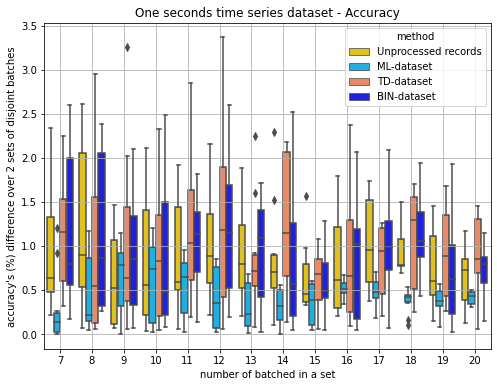

In [8]:
#compute difference across the associated batches combination 
#note that per run, we should have the results for two disjoint set of batches
df_ = df_results[(df_results['nbr_batch']!=nbr_batch)&(df_results['reliability_type']=='duration_1secTS')]
df_ = df_.filter(['method','accuracy','nbr_batch','runID','li_batch_selected'], axis=1)
display(df_.head(3))
df_acc_diff = df_.groupby(['runID','method','nbr_batch'])['accuracy','li_batch_selected'].agg(lambda x: list(x)).reset_index()
df_acc_diff['accuracy_diff'] = df_acc_diff['accuracy'].map(lambda x: abs(x[0]-x[1])*100 if len(x)==2 else np.nan)
print(df_acc_diff.shape)
df_acc_diff.to_csv(os.path.join(path_extracted_data_cleaning,'Stability_results_duration.csv'), sep=';', index=False)
display(df_acc_diff.head(3))

#plot
plt.figure(figsize=(8,6))
order = np.sort(df_acc_diff['nbr_batch'].unique())
hue_order = ['Unprocessed records', 'ML-dataset', 'TD-dataset','BIN-dataset']
ax = sns.boxplot(x="nbr_batch", y="accuracy_diff", hue="method", data=df_acc_diff, palette=pal_,order=order,hue_order=hue_order)
plt.title('One seconds time series dataset - Accuracy')
plt.xlabel('number of batched in a set')
plt.ylabel('accuracy\'s (%) difference over 2 sets of disjoint batches')
plt.grid()
plt.savefig(os.path.join(path_extracted_data_cleaning,'Stability_results_duration_1secTS.png'), bbox_inches='tight')
plt.show()

In [9]:
li = df_acc_diff['accuracy_diff'].tolist()
max(li), np.mean(li)

(3.3646386767792413, 0.8093545877198575)

### Transitions

,method,nbr_batch,runID,li_batch_selected,MAE,explained_variance_score
4,Unprocessed records,7,484e835c-a346-11eb-a877-089798b63972,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",1.142857,-0.059772
5,ML-dataset,7,484e835c-a346-11eb-a877-089798b63972,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",0.071429,0.991269
6,BIN-dataset,7,484e835c-a346-11eb-a877-089798b63972,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",0.250000,0.948455


------------------------------------------------------------- MAE


,runID,method,nbr_batch,MAE,li_batch_selected,MAE_diff
0,02ced413-a347-11eb-9083-089798b63972,BIN-dataset,15,"[0.24, 0.2533333333333333]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.013333
1,02ced413-a347-11eb-9083-089798b63972,ML-dataset,15,"[0.10666666666666667, 0.02666666666666667]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.080000
2,02ced413-a347-11eb-9083-089798b63972,TD-dataset,15,"[0.2933333333333333, 0.30666666666666664]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.013333


(560, 6)
LOOk AT THIS AND LOOK AT THE MOST EXTREME CASES:


,runID,method,nbr_batch,MAE,li_batch_selected,MAE_diff
151,587b8bc0-a346-11eb-9691-089798b63972,Unprocessed records,8,"[0.3, 1.625]","[['ID25', 'ID7', 'ID14', 'ID20', 'ID26', 'ID17...",1.325000
131,52cf6665-a346-11eb-a786-089798b63972,Unprocessed records,7,"[1.2571428571428571, 0.0]","[['ID2', 'ID21', 'ID18', 'ID19', 'ID28', 'ID37...",1.257143
199,6546ddf6-a346-11eb-bb6e-089798b63972,Unprocessed records,8,"[0.1, 1.35]","[['ID9', 'ID33', 'ID14', 'ID15', 'ID11', 'ID17...",1.250000
419,ae98b9e5-a346-11eb-a9f6-089798b63972,Unprocessed records,12,"[1.3, 0.16666666666666666]","[['ID38', 'ID23', 'ID6', 'ID35', 'ID19', 'ID28...",1.133333
159,5a3b4841-a346-11eb-b326-089798b63972,Unprocessed records,8,"[1.3125, 0.2]","[['ID29', 'ID34', 'ID13', 'ID4', 'ID19', 'ID37...",1.112500


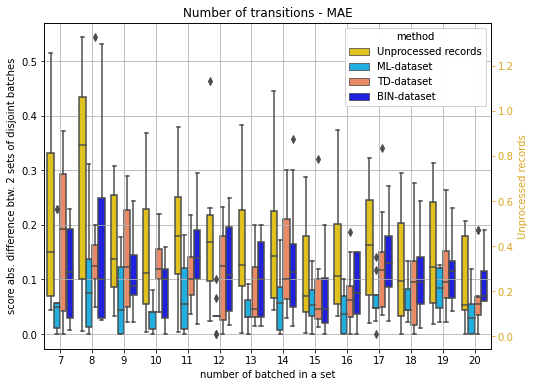

------------------------------------------------------------- EXPLAINED_VARIANCE_SCORE


,runID,method,nbr_batch,explained_variance_score,li_batch_selected,explained_variance_score_diff
0,02ced413-a347-11eb-9083-089798b63972,BIN-dataset,15,"[0.9456264775413712, 0.7697070371488977]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.175919
1,02ced413-a347-11eb-9083-089798b63972,ML-dataset,15,"[0.9794153260681544, 0.9889761401389308]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.009561
2,02ced413-a347-11eb-9083-089798b63972,TD-dataset,15,"[0.9401487631897596, 0.7697070371488977]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",0.170442


(560, 6)
LOOk AT THIS AND LOOK AT THE MOST EXTREME CASES:


,runID,method,nbr_batch,explained_variance_score,li_batch_selected,explained_variance_score_diff
367,9bc14e26-a346-11eb-956f-089798b63972,Unprocessed records,11,"[-3.4067603494113183, 0.9813640973630832]","[['ID34', 'ID10', 'ID7', 'ID6', 'ID30', 'ID1',...",4.388124
3,02ced413-a347-11eb-9083-089798b63972,Unprocessed records,15,"[0.8612120163754828, -2.5374509211718497]","[['ID18', 'ID1', 'ID35', 'ID20', 'ID21', 'ID33...",3.398663
151,587b8bc0-a346-11eb-9691-089798b63972,Unprocessed records,8,"[0.8643533123028391, -2.529174725983236]","[['ID25', 'ID7', 'ID14', 'ID20', 'ID26', 'ID17...",3.393528
387,a29f7d7e-a346-11eb-807f-089798b63972,Unprocessed records,11,"[0.8772355928461029, -1.8690476190476195]","[['ID33', 'ID26', 'ID21', 'ID7', 'ID23', 'ID32...",2.746283
111,4e3fe53e-a346-11eb-8c21-089798b63972,Unprocessed records,7,"[-0.5414392059553346, -3.2716823406478572]","[['ID14', 'ID17', 'ID33', 'ID8', 'ID10', 'ID30...",2.730243


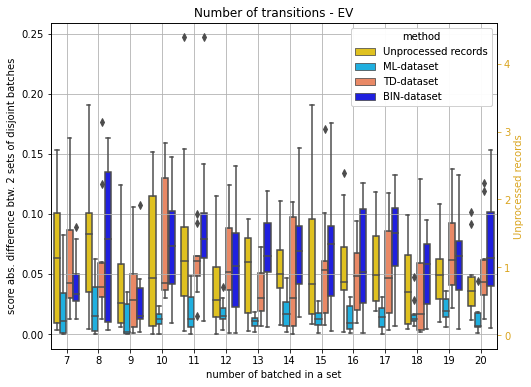

In [10]:
li_score = ['MAE','explained_variance_score']
df_ = df_results[(df_results['nbr_batch']!=nbr_batch)&(df_results['reliability_type']=='transitions')]    
df_ = df_.filter(['method','nbr_batch','runID','li_batch_selected']+li_score, axis=1)
display(df_.head(3))

#compute&plot diff. across the associated batches combination. Per run, we should have the results for 2 disjoint set of batches
for s in li_score:
    print('------------------------------------------------------------- '+s.upper())
    ##################################### compute diff in scores
    df_diff = df_.groupby(['runID','method','nbr_batch'])[[s,'li_batch_selected']].agg(lambda x: list(x)).reset_index()
    df_diff[s+'_diff'] = df_diff[s].map(lambda x: abs(x[0]-x[1]) if len(x)==2 else np.nan)
    display(df_diff.head(3))
    print(df_diff.shape)
    df_diff.to_csv(os.path.join(path_extracted_data_cleaning,'Stability_results_transition_'+s+'.csv'),sep=';',index=False)
    print('LOOk AT THIS AND LOOK AT THE MOST EXTREME CASES:')
    display(df_diff.sort_values([s+'_diff'], ascending=False).head(5))
    
    ##################################### plot
    plt.figure(figsize=(8,6))
    
    ############# without tracking zone
    df__1 = df_diff.copy()
    df__1.loc[df__1['method']=='Unprocessed records', s+'_diff'] = np.nan
    order = np.sort(df__1['nbr_batch'].unique()) #x-axis order
    hue_order = ['Unprocessed records', 'ML-dataset', 'TD-dataset','BIN-dataset']
    ax1 = sns.boxplot(x="nbr_batch", y=s+'_diff', hue="method", data=df__1, palette=pal_, order=order, hue_order=hue_order)
    plt.xlabel('number of batched in a set')
    plt.ylabel('score abs. difference btw. 2 sets of disjoint batches')
    plt.grid()
    
    ############# with only tracking zone
    df__2 = df_diff.copy()
    df__2.loc[df__2['method']!='Unprocessed records', s+'_diff'] = np.nan
    ax2 = ax1.twinx()
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.tick_params(axis='y', colors='goldenrod')
    sns.boxplot(x="nbr_batch", y=s+'_diff', hue="method", data=df__2, palette=pal_, order=order, hue_order=hue_order)#, boxprops=dict(alpha=0.7)) #palette="Set3")
    plt.title('Number of transitions - '+s.replace('explained_variance_score','EV'))
    plt.ylabel('Unprocessed records', color='goldenrod')
    plt.savefig(os.path.join(path_extracted_data_cleaning,'Stability_results_transitions_'+s+'.png'), bbox_inches='tight')
    plt.show();

In [11]:
y_true = [1,2,4,7]
y_pred = [7,6,4,1]
explained_variance_score(y_true, y_pred)

-3.0

# Evaluation of performance measures on the 1secTS

In [12]:
df_plt = df_results[(df_results['nbr_batch']==nbr_batch)&\
                    (df_results['reliability_type']=='duration_1secTS')]
df_plt = pd.melt(df_plt, id_vars=['runID','CPairID','method','reliability_type'], 
                 value_vars=['accuracy','macroavg_precision', 'macroavg_recall'])
df_plt.sort_values(['method'])

,runID,CPairID,method,reliability_type,variable,value
2,c2fdf670-a347-11eb-afe2-089798b63972,0,BIN-dataset,duration_1secTS,accuracy,0.973926
6,c2fdf670-a347-11eb-afe2-089798b63972,0,BIN-dataset,duration_1secTS,macroavg_precision,0.970904
10,c2fdf670-a347-11eb-afe2-089798b63972,0,BIN-dataset,duration_1secTS,macroavg_recall,0.973228
1,c2fdf670-a347-11eb-afe2-089798b63972,0,ML-dataset,duration_1secTS,accuracy,0.997310
5,c2fdf670-a347-11eb-afe2-089798b63972,0,ML-dataset,duration_1secTS,macroavg_precision,0.997540
9,c2fdf670-a347-11eb-afe2-089798b63972,0,ML-dataset,duration_1secTS,macroavg_recall,0.997052
3,c2fdf670-a347-11eb-afe2-089798b63972,0,TD-dataset,duration_1secTS,accuracy,0.979166
7,c2fdf670-a347-11eb-afe2-089798b63972,0,TD-dataset,duration_1secTS,macroavg_precision,0.977026
11,c2fdf670-a347-11eb-afe2-089798b63972,0,TD-dataset,duration_1secTS,macroavg_recall,0.979059
0,c2fdf670-a347-11eb-afe2-089798b63972,0,Unprocessed records,duration_1secTS,accuracy,0.991363


In [13]:
df_results.head(3)

,accuracy,support,macroavg_precision,macroavg_recall,macroavg_f1,weightedavg_precision,weightedavg_recall,weightedavg_f1,2_Zone_precision,2_Zone_recall,...,li_batch_selected,nbr_batch,CPairID,RMSE,MAE,explained_variance_score,1_Zone_precision,1_Zone_recall,1_Zone_f1-score,1_Zone_support
0,0.990674,49327,0.989783,0.987169,0.988240,0.989783,0.987169,0.988240,1.000000,0.999657,...,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.999696,49327,0.999657,0.999592,0.999624,0.999657,0.999592,0.999624,1.000000,1.000000,...,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.972307,49327,0.970441,0.969374,0.969676,0.970441,0.969374,0.969676,0.988659,0.982555,...,"['ID35', 'ID15', 'ID21', 'ID19', 'ID16', 'ID8'...",7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Evaluation of performance measures on the transitions

In [14]:
df_rel_transitions['variable'].value_counts()

1_Zone    42
2_Zone    42
3_Zone    42
4_Zone    42
5_Zone    42
Name: variable, dtype: int64

In [15]:
df_rel_transitions.head(3)

,BatchID,variable,ThresholdOnDuration_Zone,Binning_Zone,Observed_Zone,Model_Zone,Trackingsystem_Zone,PenID
0,ID1,2_Zone,3,3,3,3,5,pen3
1,ID10,2_Zone,3,3,3,3,3,pen9
2,ID11,2_Zone,2,3,2,2,4,pen9


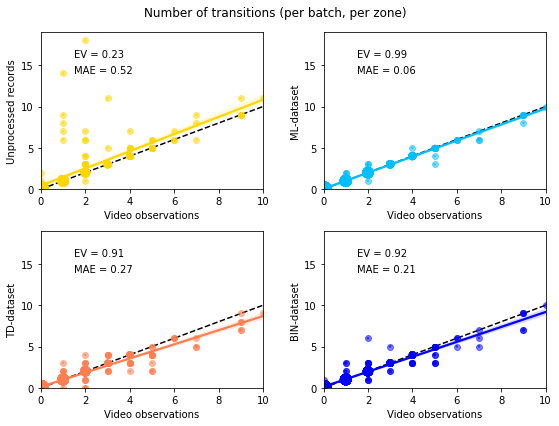

In [21]:
#with regression line
dico_name_title = {'Trackingsystem_Zone':'Unprocessed records',
                   'ThresholdOnDuration_Zone':'TD-dataset', 
                   'Binning_Zone':'BIN-dataset',
                   'Model_Zone':'ML-dataset'}
fig = plt.figure(figsize=(8,6))
for i,y_ in enumerate(['Trackingsystem_Zone','Model_Zone','ThresholdOnDuration_Zone', 'Binning_Zone']):
    x = np.array(df_rel_transitions['Observed_Zone'].tolist())
    y = np.array(df_rel_transitions[y_].tolist())
    Explvarscore = explained_variance_score(x, y)
    MAE = mean_absolute_error(x, y)
    plt.subplot(2,2,i+1)
    plt.ylim([0, 19]) #defined after we saw all plot
    plt.tight_layout()
    ax = sns.regplot(x=x,y=y,color=pal_[y_],ci=95, scatter_kws={'alpha':0.5})
    #add text
    ax.set_xlabel('Video observations')
    ax.set_ylabel(dico_name_title[y_])
    ax.text(1.5, 16, 'EV = ' + str(np.round(Explvarscore,2)))
    ax.text(1.5, 14, 'MAE = ' + str(np.round(MAE,2)))
    #ax.text(1, max(y)-int(0.12*max(y)), 'EV = ' + str(np.round(Explvarscore,2)))
    #ax.text(1, max(y)-int(0.24*max(y)), 'MAE = ' + str(np.round(MAE,2)))
    ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0) #add diagonal line
    #add scatter plot with size
    c = Counter(zip(x,y)) # count the occurrences of each point
    s = [3*c[(xx,yy)] for xx,yy in zip(x,y)] # create a list of the sizes, here multiplied by 5 for scale to see the actual diff
    ax.scatter(x, y, s, color=pal_[y_], alpha=0.5) 
#save
plt.suptitle('Number of transitions (per batch, per zone)')
plt.tight_layout()
plt.savefig(os.path.join(path_extracted_data_cleaning, "Transition_reliability.png"),
            dpi=300,format='png',bbox_inches='tight')
plt.show()

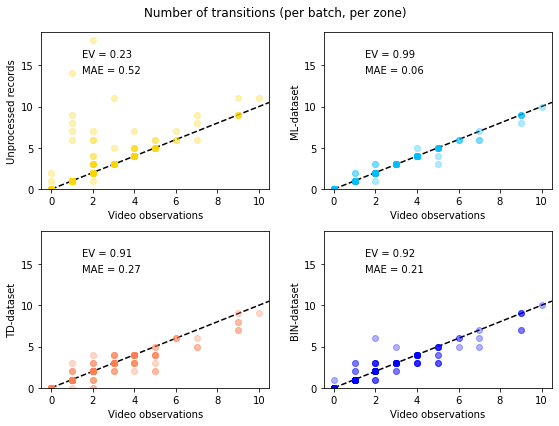

In [35]:
#without regression line
dico_name_title = {'Trackingsystem_Zone':'Unprocessed records',
                   'ThresholdOnDuration_Zone':'TD-dataset', 
                   'Binning_Zone':'BIN-dataset',
                   'Model_Zone':'ML-dataset'}
fig = plt.figure(figsize=(8,6))
for i,y_ in enumerate(['Trackingsystem_Zone','Model_Zone','ThresholdOnDuration_Zone', 'Binning_Zone']):
    x = np.array(df_rel_transitions['Observed_Zone'].tolist())
    y = np.array(df_rel_transitions[y_].tolist())
    Explvarscore = explained_variance_score(x, y)
    MAE = mean_absolute_error(x, y)
    plt.subplot(2,2,i+1)
    plt.ylim([0, 19]) #defined after we saw all plot
    plt.tight_layout()
    #add text
    plt.xlabel('Video observations')
    plt.ylabel(dico_name_title[y_])
    plt.text(1.5, 16, 'EV = ' + str(np.round(Explvarscore,2)))
    plt.text(1.5, 14, 'MAE = ' + str(np.round(MAE,2)))
    #plt.text(1, max(y)-int(0.12*max(y)), 'EV = ' + str(np.round(Explvarscore,2)))
    #plt.text(1, max(y)-int(0.24*max(y)), 'MAE = ' + str(np.round(MAE,2)))
    plt.axline((0, 0), slope=1, c="black", ls="--", zorder=0) #add diagonal line
    #add scatter plot with size
    c = Counter(zip(x,y)) # count the occurrences of each point
    #s = [3*c[(xx,yy)] for xx,yy in zip(x,y)] # create a list of the sizes, here multiplied by 5 for scale to see the actual diff
    plt.scatter(x, y, color=pal_[y_], alpha=0.3)  # s,
#save
plt.suptitle('Number of transitions (per batch, per zone)')
plt.tight_layout()
plt.savefig(os.path.join(path_extracted_data_cleaning, "Transition_reliability.png"),
            dpi=300,format='png',bbox_inches='tight')
plt.show()

the minimum support is 42
the minimum support is 42


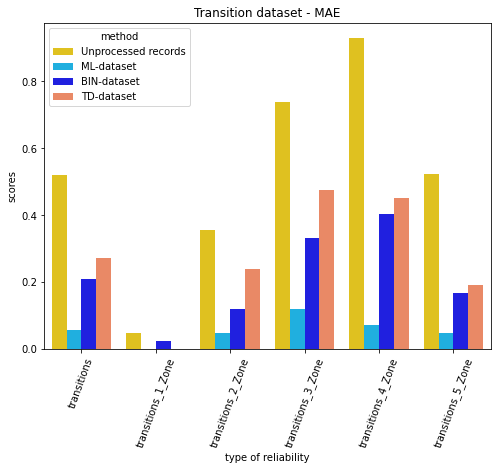

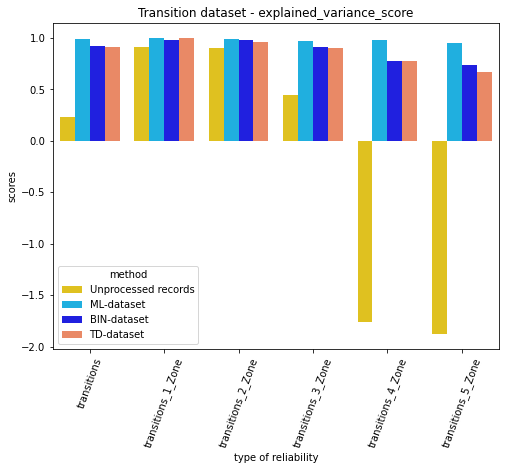

In [16]:
#just to verify if the above results correspond to the one find previousinly (in 4_1CleaningMethodsComparison_Computation.ipynb)
#note that we can't remove this computation from the previous script as it was done on a lot of different set of batches
#for the stability results! that was the main purpose of it :)
li_rel_type = ['transitions','transitions_1_Zone', 'transitions_2_Zone', 'transitions_3_Zone', 'transitions_4_Zone', 
               'transitions_5_Zone']
li_score = ['MAE','explained_variance_score']
for v in li_score:
    df_plt = df_results[(df_results['nbr_batch']==nbr_batch)&\
                        (df_results['reliability_type'].isin(li_rel_type))][['reliability_type','method','support',v]]
    #display(df_plt.head(3))
    print('the minimum support is %s'%min(df_plt['support'].tolist()))
    df_plt = pd.melt(df_plt, id_vars=['method','support','reliability_type'], value_vars=[v])
    #display(df_plt.head(3))

    plt.figure(figsize=(8,6))
    ax = sns.barplot(x="reliability_type", y="value", hue="method", data=df_plt, palette=pal_)
    plt.xticks(fontsize=10,rotation=70)
    #plt.ylim(0.6,1)
    plt.xlabel('type of reliability')
    plt.ylabel('scores');
    plt.title('Transition dataset - '+v)
    plt.savefig(os.path.join(path_extracted_data_cleaning,
                             "ReliabilityMethodsComparison_transition_"+v+".png"), bbox_inches='tight')